In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd
import statsmodels.graphics.api as smg
from sklearn.model_selection import train_test_split
import seaborn as sns
import pylab as py

In [2]:
data = pd.read_csv("./data/data.csv")

In [3]:
all_data_to_plot = data.drop(columns=["ID", "salary_cap_perc"])

C:\Users\azernaczuk\AppData\Local\Temp\ipykernel_27636\2620940592.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


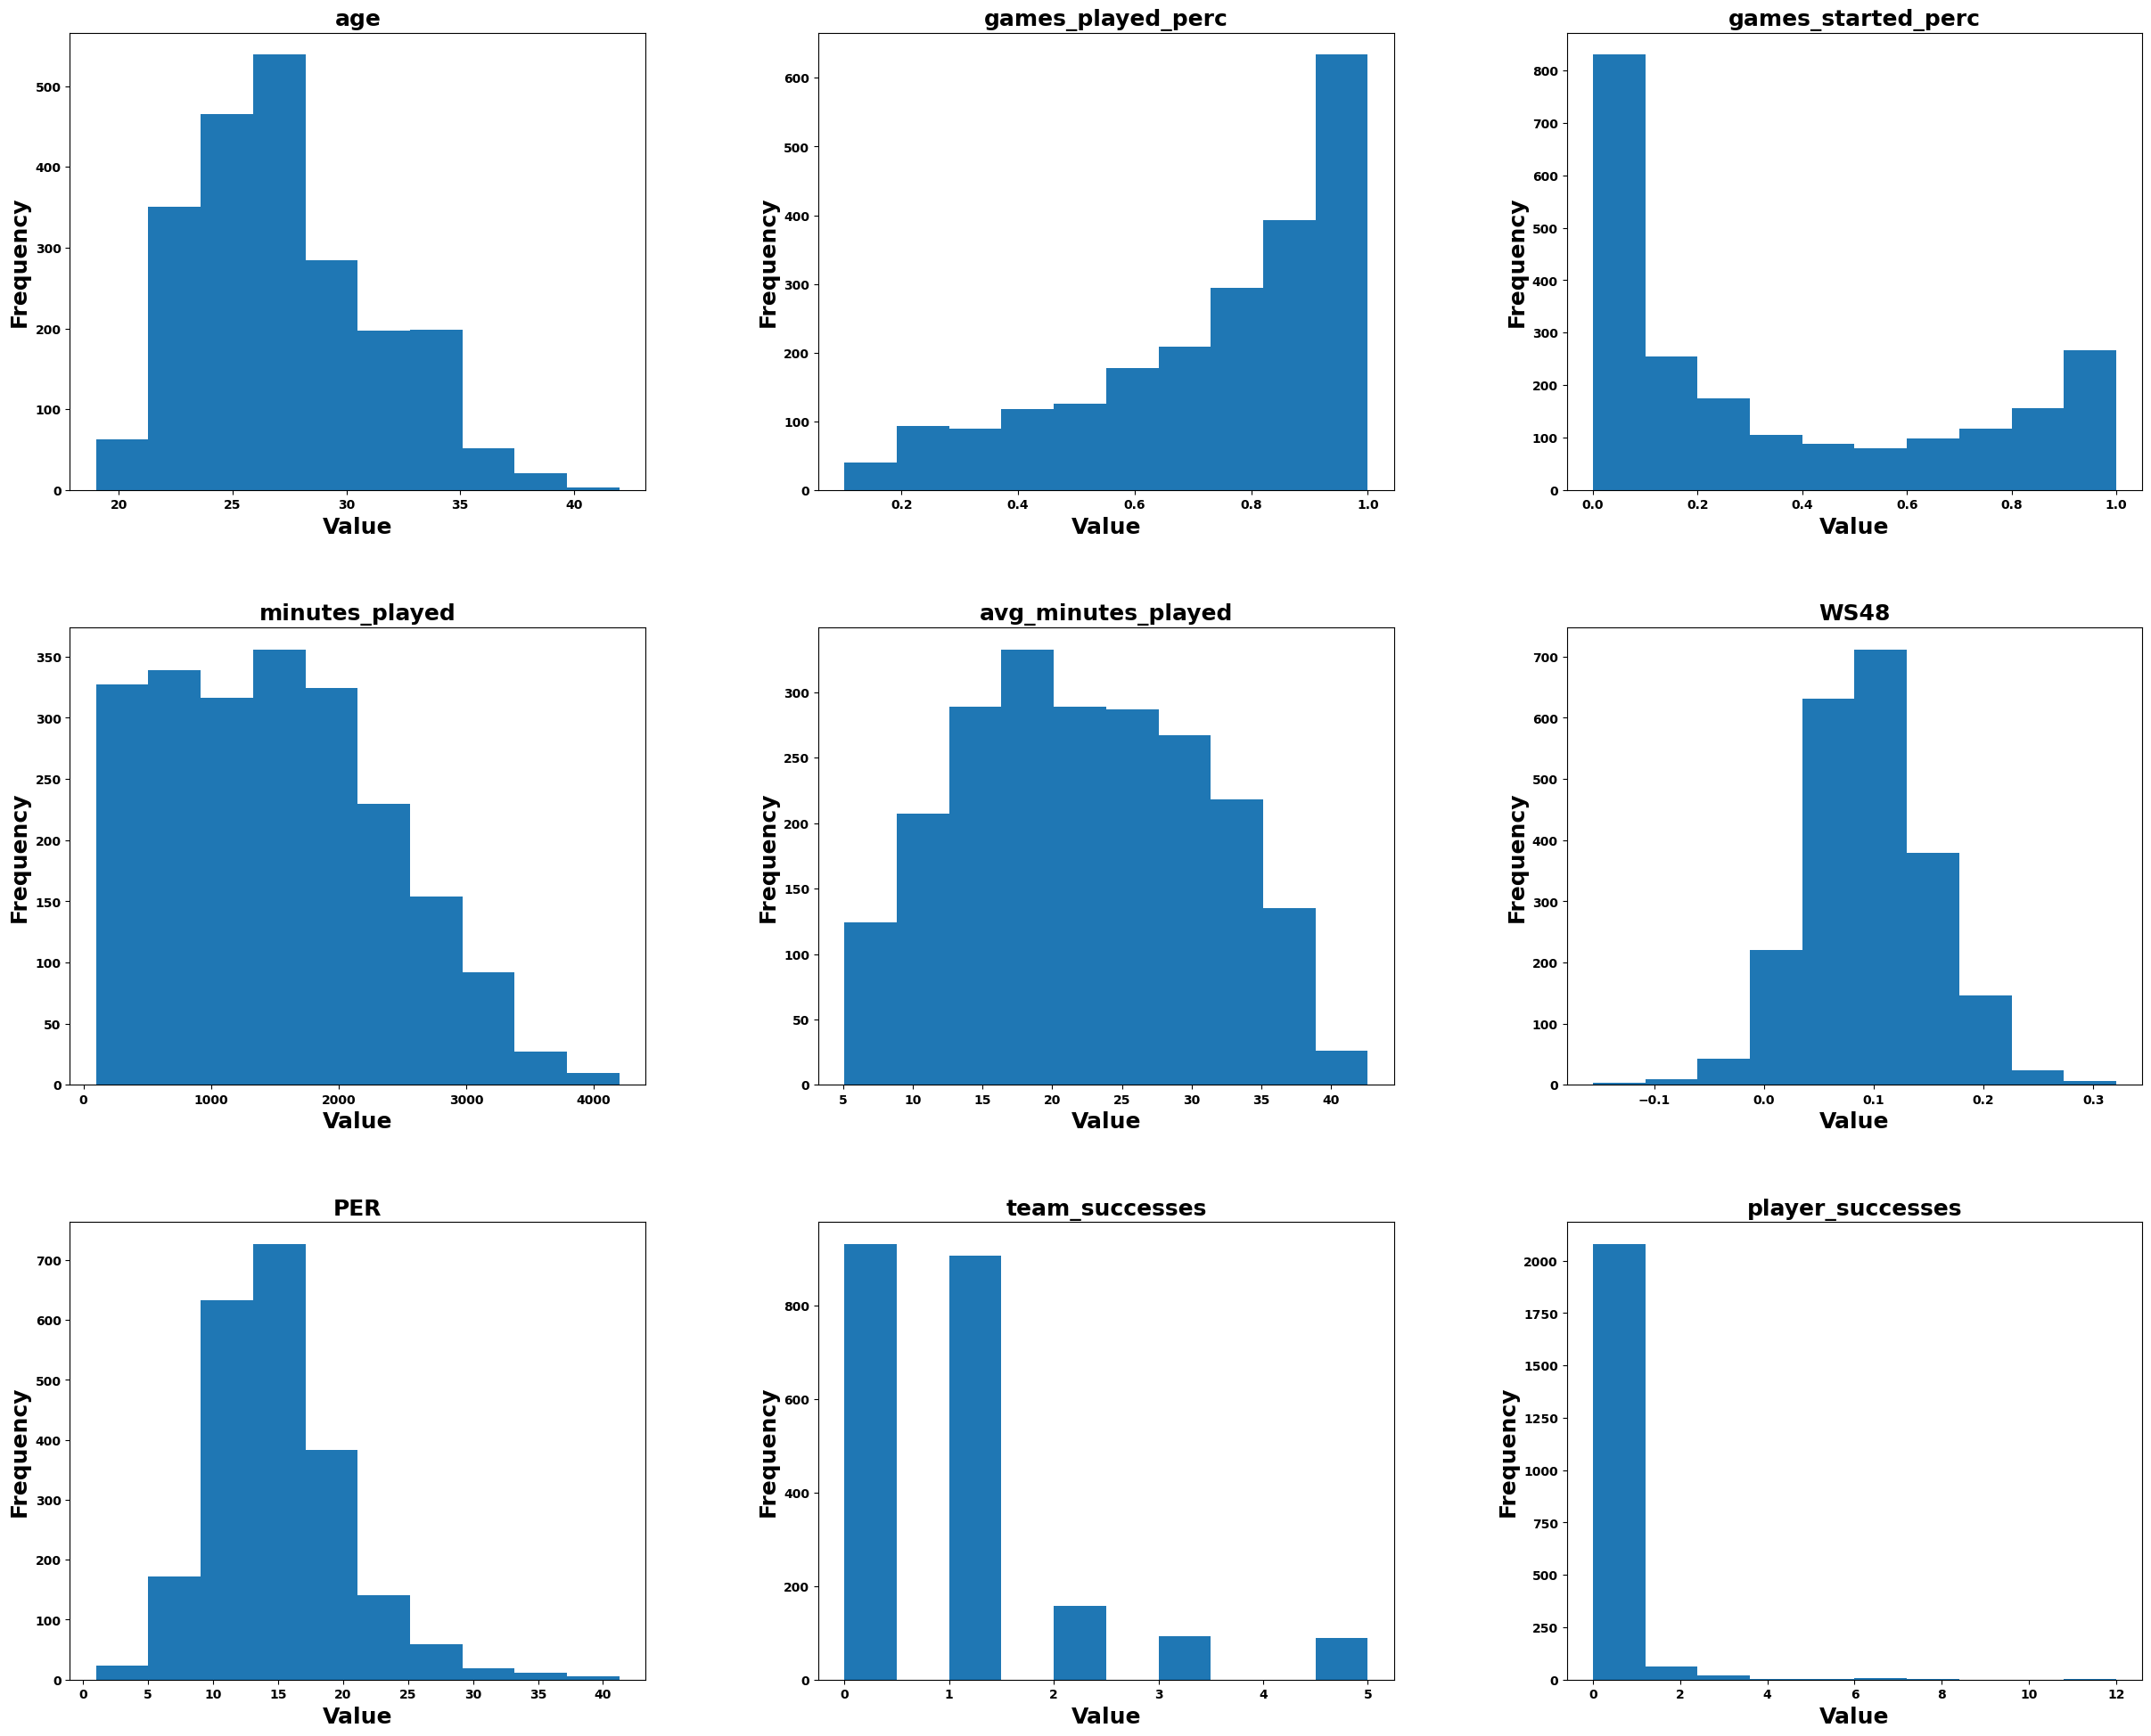

In [5]:
fig = plt.figure(figsize=(30, 24))
plt.rcParams['font.weight'] = 'bold'
gs = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, colum in enumerate(all_data_to_plot.columns):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col]) # Indexing starts at 1, not 0
    ax.hist(all_data_to_plot[colum])
    ax.set_title(f'{colum}', weight='bold', fontsize=18)
    ax.set_xlabel('Value', weight='bold', fontsize=18)
    ax.set_ylabel('Frequency', weight='bold', fontsize=18)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

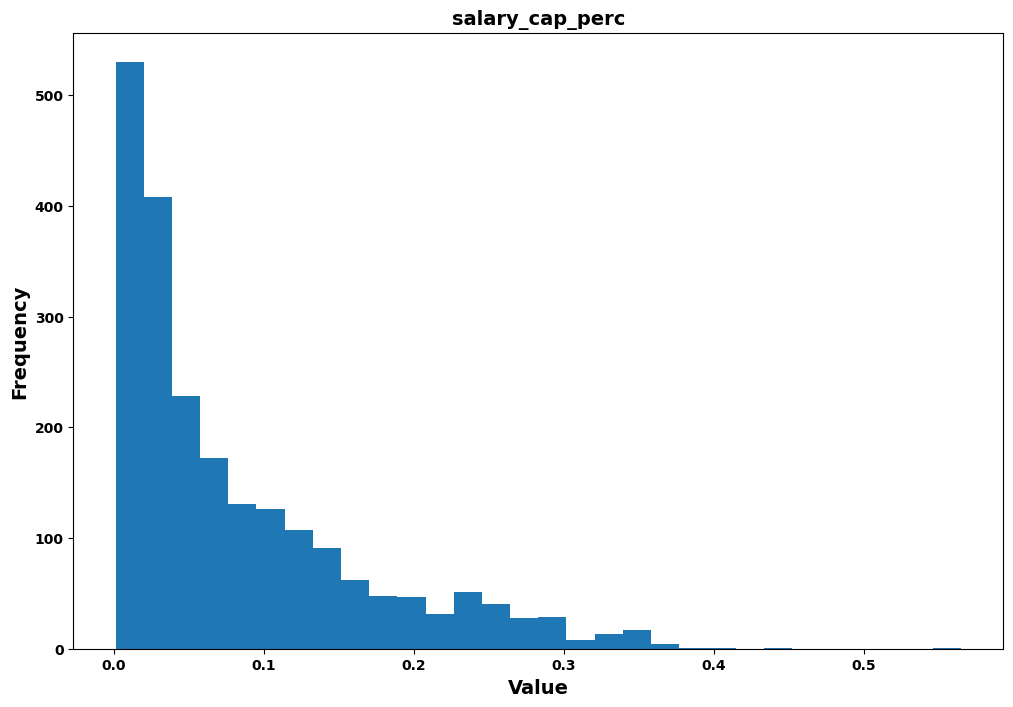

In [6]:
plt.rcParams['font.weight'] = 'bold'

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram
ax.hist(data["salary_cap_perc"], bins=30)

# Set the title, x-axis label, and y-axis label
ax.set_title(f'salary_cap_perc', weight='bold', fontsize=14)
ax.set_xlabel('Value', weight='bold', fontsize=14)
ax.set_ylabel('Frequency', weight='bold', fontsize=14)

# Show the plot
plt.show()

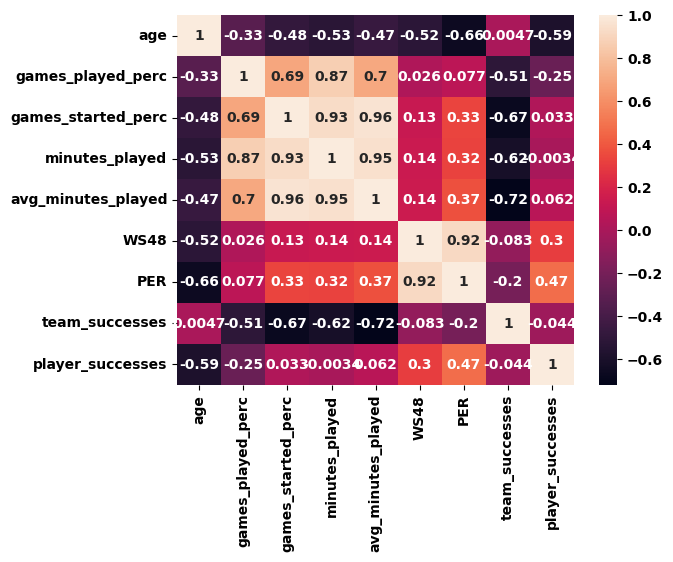

In [7]:
htmp = data.drop(columns=["ID", "salary_cap_perc"])
htmp_data = htmp.corr()
sns.heatmap(htmp_data.corr(), annot=True)
plt.show()

In [8]:
X = data.drop(columns={"ID", "salary_cap_perc"})
y = data["salary_cap_perc"]

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [39]:
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

In [ ]:
X_train = pd.read_csv("./data/X_train.csv", encoding='utf-8')
X_test = pd.read_csv("./data/X_test.csv", encoding='utf-8')
y_train = pd.read_csv("./data/y_train.csv", encoding='utf-8')
y_test = pd.read_csv("./data/y_test.csv", encoding='utf-8')

In [ ]:
train_df = X_train.copy()
train_df["salary_cap_perc"] = y_train.copy()
train_df

In [54]:
reg = smf.ols(formula='np.log(salary_cap_perc) ~ np.log2(age) + WS48 + team_successes + player_successes + avg_minutes_played + games_played_perc', data=train_df)
results = reg.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log(salary_cap_perc)   R-squared:                       0.585
Model:                                 OLS   Adj. R-squared:                  0.583
Method:                      Least Squares   F-statistic:                     457.4
Date:                     Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                             04:03:33   Log-Likelihood:                -2300.4
No. Observations:                     1957   AIC:                             4615.
Df Residuals:                         1950   BIC:                             4654.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [44]:
results_np = sm.OLS(results.model.endog, results.model.exog).fit()

In [50]:
y_pred = results.predict(X_test)

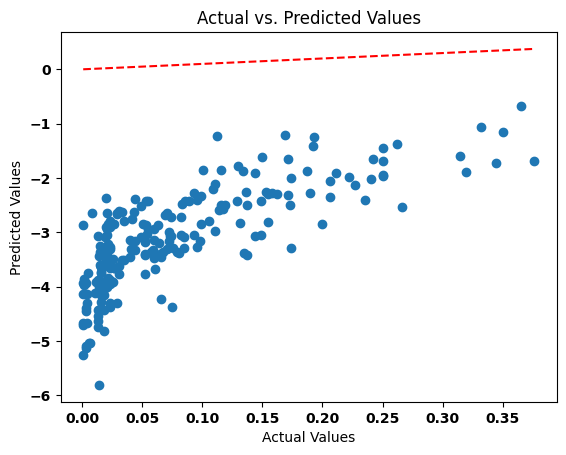

In [51]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

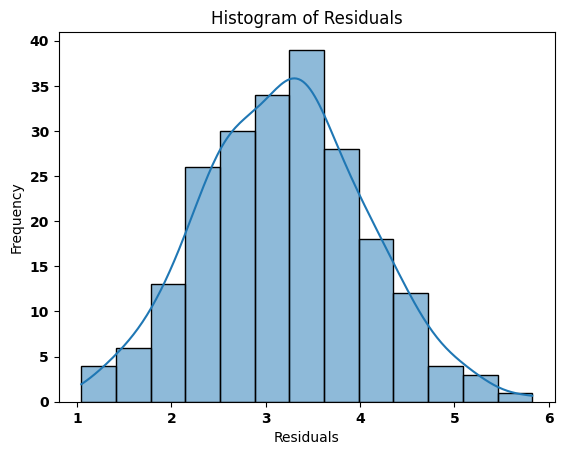

In [52]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [53]:
# test reset
reset_test = smd.linear_reset(res=results_np, use_f = True)
reset_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=24.927287260522682, p=2.0437514160822977e-11, df_denom=1.95e+03, df_num=2>

In [55]:
# rainbow
rainbow = smd.linear_rainbow(results_np)

labels = ['F-Statistic', 'F-Test p-value']


print(dict(zip(labels, rainbow)))

{'F-Statistic': 0.9935828110282858, 'F-Test p-value': 0.5400550951971008}


In [47]:
# WHITE TEST
white_test = smd.het_white(results.resid,  results.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 204.43033204390082, 'Test Statistic p-value': 3.5507276644539846e-29, 'F-Statistic': 8.333712358210038, 'F-Test p-value': 4.802013874690245e-31}


In [48]:
# BREUSCH-PAGAN TEST
bp_test = smd.het_breuschpagan(results.resid, results.model.exog)
#define labels to use for output of BP test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of BP test
print(dict(zip(labels, bp_test)))

{'Test Statistic': 163.47439396532914, 'Test Statistic p-value': 1.0874803888445296e-32, 'F-Statistic': 29.622759697418523, 'F-Test p-value': 3.941232540587561e-34}


In [49]:
# BREUSCH-GODFREY TEST
bg_test = smd.acorr_breusch_godfrey(results)

#define labels to use for output of BP test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of BP test
print(dict(zip(labels, bg_test)))

{'Test Statistic': 14.723766821689342, 'Test Statistic p-value': 0.14246205447498228, 'F-Statistic': 1.4706511435468943, 'F-Test p-value': 0.14412331354496943}


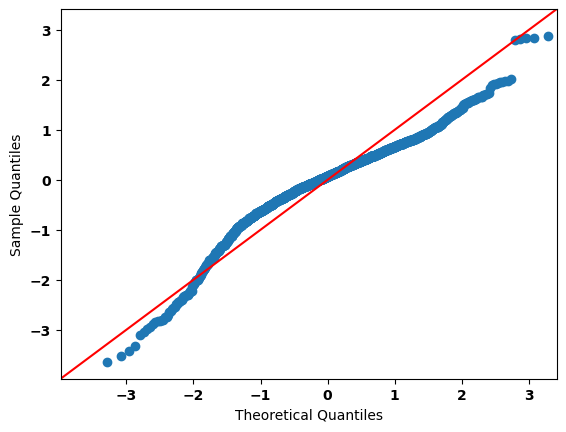

In [56]:
data_points = results_np.resid 

sm.qqplot(data_points, line ='45')
py.show()

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

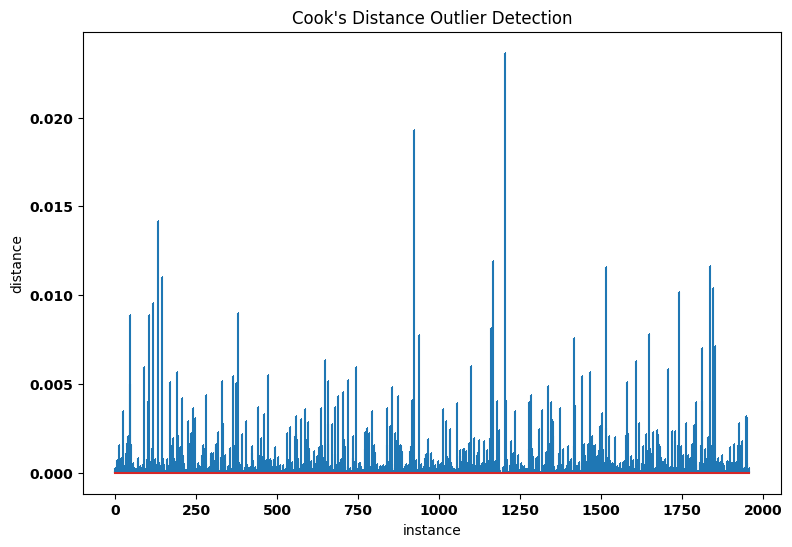

In [57]:
#create instance of influence
influence = results.get_influence()

#obtain Cook's distance for each observation
C, P = influence.cooks_distance

def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax

plot_cooks_distance(C)